Solving the Diffusion equation
$$
\begin{aligned}
&\begin{aligned}
& \frac{\partial \bar{B}_r}{\partial t}= \eta \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_r\right)\right]-\eta \frac{\partial^2 \bar{B}_r}{\partial z^2} , \\
& \frac{\partial \bar{B}_\phi}{\partial t}=\eta \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_\phi\right)\right] -\eta \frac{\partial^2 \bar{B}_\phi}{\partial z^2} \\
\end{aligned}
\end{aligned}
$$

Using no-z approximtion. We get the equations as follows:
$$
\begin{aligned}
&\begin{aligned}
& \frac{\partial \bar{B}_r}{\partial t}= \eta \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_r\right)\right] - \eta \frac{\pi^2}{4h^2} \bar{B}_r , \\
& \frac{\partial \bar{B}_\phi}{\partial t}=\eta \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_\phi\right)\right] - \eta \frac{\pi^2}{4h^2} \bar{B}_\phi\\
\end{aligned}
\end{aligned}
$$

Now making the same equations Dimensionaless
$$
\begin{aligned}
&\begin{aligned}
& \frac{\partial \bar{B}_r}{\partial t}= \left(\frac{h_0}{R_0}\right)^2 \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_r\right)\right] - \frac{\pi^2 \bar{B}_r}{4}, \\
& \frac{\partial \bar{B}_\phi}{\partial t}=\left(\frac{h_0}{R_0}\right)^2 \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_\phi\right)\right] - \frac{\pi^2 \bar{B}_\phi}{4}\\
\end{aligned}
\end{aligned}
$$



# Boundary Conditions
$$
Br(R_0)= 0 =Br(0)\\
B_\phi(R_0)=0 = B_\phi(0)\\
$$

In [44]:
# Librarires
import numpy as np
import matplotlib.pyplot as plt

#Define Constants
h=0.5 #kpc

#Define radial grid parameters
r_min = 0.01   # Minimum radial coordinate
r_max = 20   # Maximum radial coordinate
Nr_old = 100      # Number of grid points
dr= (r_max - r_min)/Nr_old

#Define Time parameters
t_min = 0
t_max = 3 #Myr
Nt = 10000
t_values= np.linspace(t_min,t_max,Nt)
dt = (t_max - t_min)/Nt

# Ghost Zone Implementation

In [45]:
# Define the number of ghost zones
num_ghost_zones = 5

#extend the spatial grid
r_min_new= r_min- num_ghost_zones*dr
r_max_new =  r_max + num_ghost_zones*dr

Nr= Nr_old + 2*num_ghost_zones+1

# Create radial grid
r_values= np.linspace(r_min_new,r_max_new,Nr)


# Defining the seed magnetic field

In [46]:
#Define initial see magnetic field
Br= np.sin(np.pi*(r_min-r_values)/(r_max-r_min))
Bphi= (-1)*np.sin(np.pi*(r_min-r_values)/(r_max-r_min))

In [47]:
#Going for the RHS
def First_term(B_r):
    return h**2/r_max**2 * np.gradient(1/r_values * np.gradient(r_values * B_r,dr),dr)
    
def Second_term(B_r):
    return (np.pi**2 *B_r)/(4)

def RHS(B_r):
    return (First_term(B_r) - Second_term(B_r))

# RK4 Integration

In [48]:
# Function to perform RK4 time integration
def rk4_integration(B_r,B_phi):
    k1 = dt * RHS(B_r)
    k2 = dt * RHS(B_r + 0.5 * k1)
    k3 = dt * RHS(B_r + 0.5 * k2)
    k4 = dt * RHS(B_r + k3)
    
    l1 = dt * RHS(B_phi)
    l2 = dt * RHS(B_phi+ 0.5 * l1)
    l3 = dt * RHS(B_phi + 0.5 * l2)
    l4 = dt * RHS(B_phi + l3)
    
    B_r_new = B_r + (k1 + 2*k2 + 2*k3 + k4) / 6
    B_phi_new = B_phi + (l1 +2*l2 + 2*l3 + l4)/6
    
    # Define the Boundary Conditions
    B_r_new[5]=0
    B_phi_new[-6]=0
    B_r_new[-6]=0
    B_phi_new[5]=0
    
    for i in range(num_ghost_zones):
        B_r_new[5-i]=B_r_new[5+i]
        B_phi_new[5-i]=B_phi_new[5+i]
        B_r_new[-6+i]=B_r_new[-6-i]
        B_phi_new[-6+i]=B_phi_new[-6-i]
    
    
    return B_r_new,B_phi_new

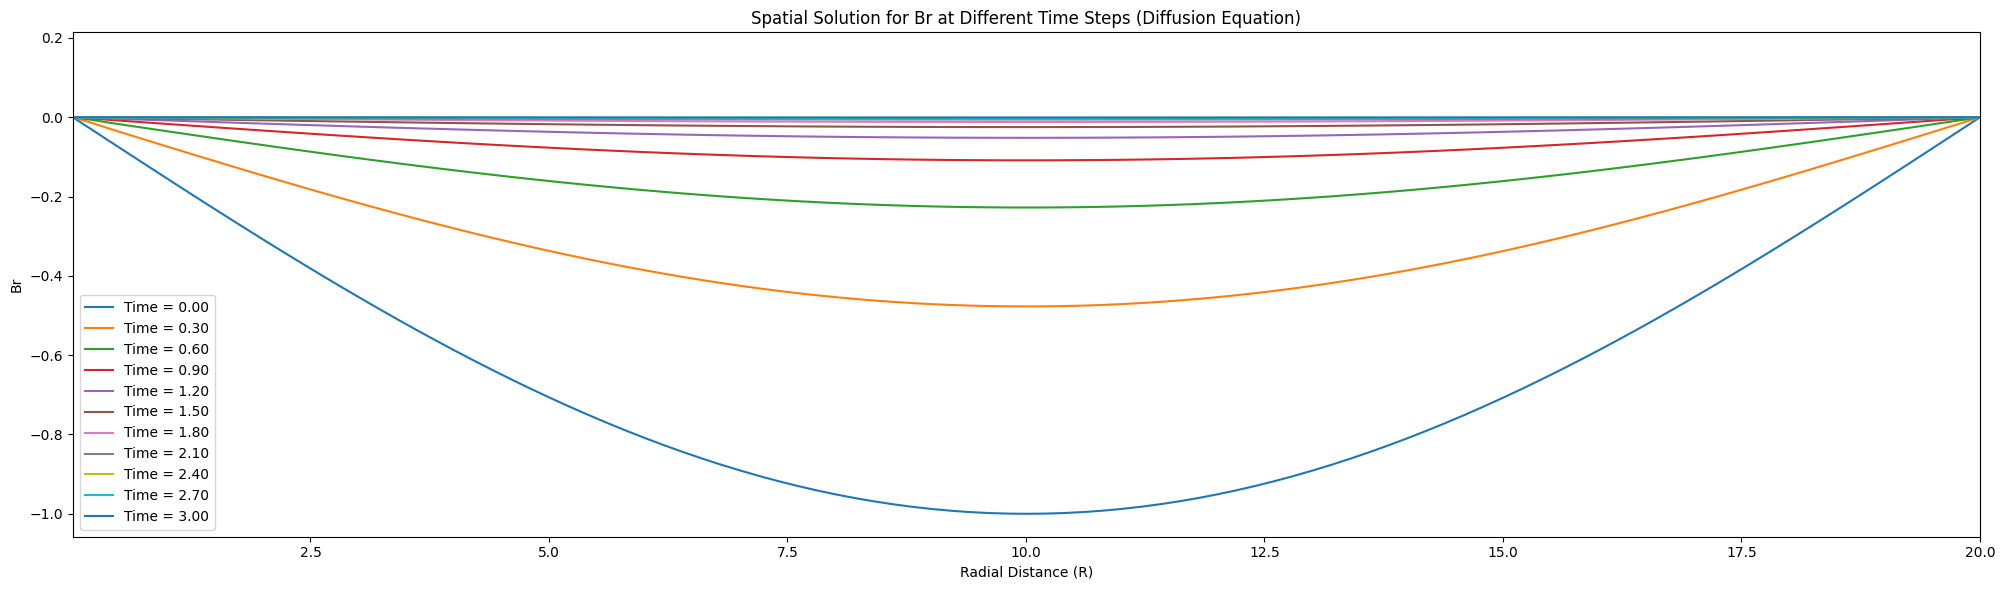

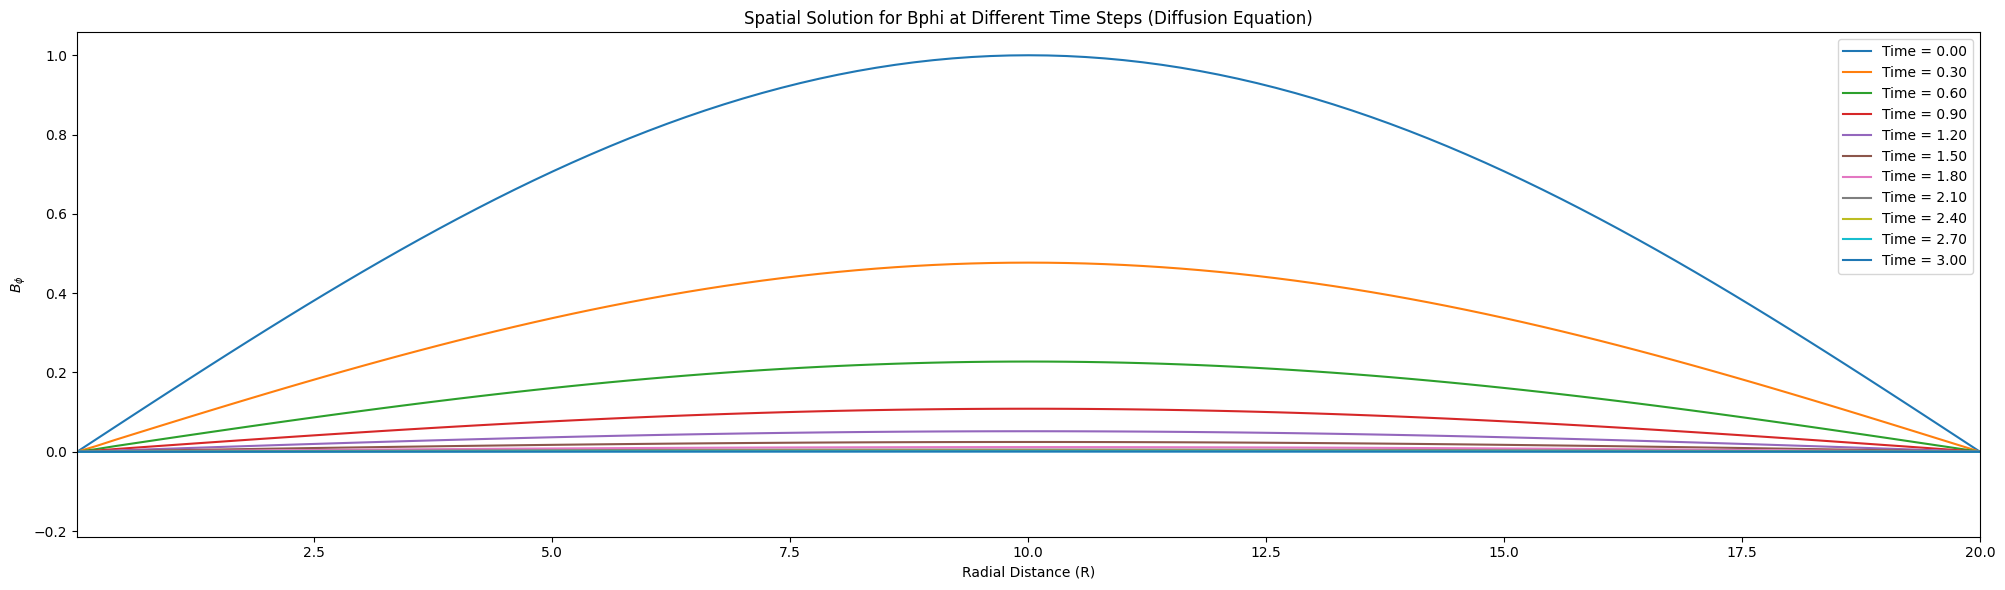

In [49]:

# Br and Bphi are functions of Space and time. Here we are considering only r-direction. 
# We will create 2D array, where each column specifies the field evolution w.r.to time at a given radial distance.
# Similrly rows specifies field evolution w.r.to radial distance at a given time step.
Br_Evolution = np.zeros((Nt + 1, Nr))
Bphi_Evolution = np.zeros((Nt + 1, Nr))

# Time-stepping scheme using Runge-Kutta
for t in range(Nt + 1):
    Br_Evolution[t, :] = np.copy(Br)
    Bphi_Evolution[t, :] = np.copy(Bphi)
    Br,Bphi = rk4_integration(Br,Bphi)
    
# Plot the spatial solution for Br
plt.figure(figsize=(20, 6))
for t in range(0, Nt + 1, Nt // 10):  # Plot every 10th time step
    plt.plot(r_values, Br_Evolution[t, :], label=f'Time = {t * dt:.2f}')
plt.xlabel('Radial Distance (R)')
plt.ylabel('Br')
plt.title('Spatial Solution for Br at Different Time Steps (Diffusion Equation)')
plt.legend()
plt.tight_layout()
plt.xlim(r_min,r_max)
plt.show()

# Plot the spatial solution for Bphi
plt.figure(figsize=(20, 6))
for t in range(0, Nt + 1, Nt // 10):  # Plot every 10th time step
    plt.plot(r_values, Bphi_Evolution[t, :], label=f'Time = {t * dt:.2f}')
plt.xlabel('Radial Distance (R)')
plt.ylabel(r'$B_\phi$')
plt.title('Spatial Solution for Bphi at Different Time Steps (Diffusion Equation)')
plt.legend()
plt.tight_layout()
plt.xlim(r_min,r_max)
plt.show()

# Exponential Decay Rate

$$
\text{The solution after a long time turns out in the form of exponential}\\
\begin{aligned}
log_{10}(Br) = \gamma ~ t ~ log_{10}(e) + constant
\end{aligned}
$$

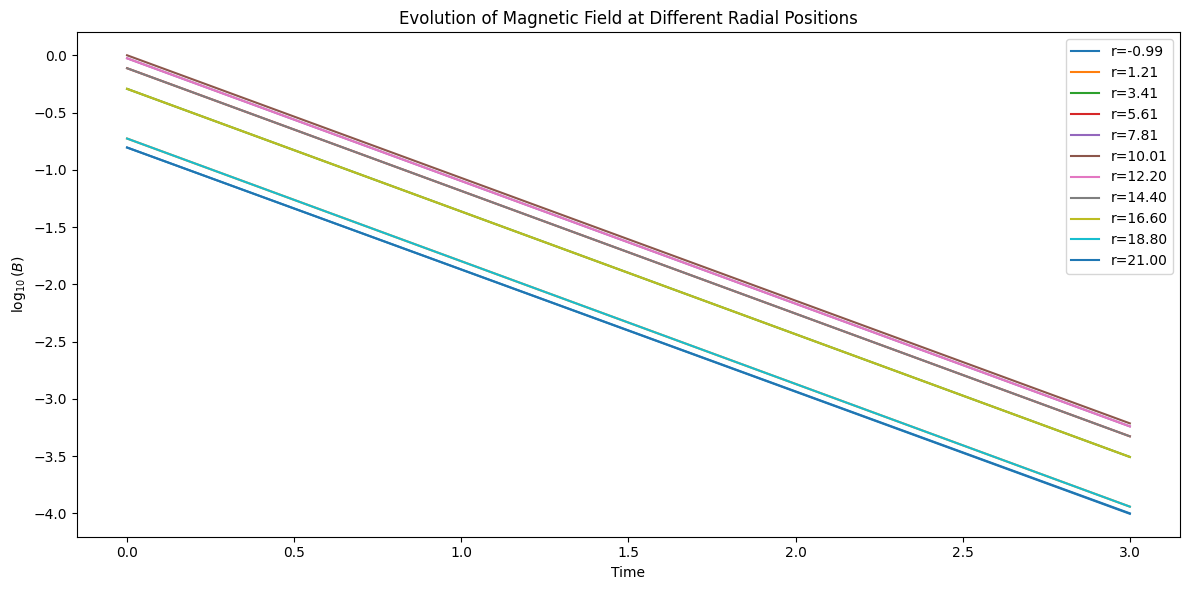

In [50]:
# Plot the evolution of magnetic field at different radial positions over time
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, t_max, Nt + 1),np.log10(np.abs(Br_Evolution[:, ::Nr//10])))
plt.xlabel('Time')
plt.ylabel(r'$\log_{10}(B)$')
plt.title('Evolution of Magnetic Field at Different Radial Positions')
plt.legend([f'r={r_values[i]:.2f}' for i in range(0, Nr, Nr//10)])
plt.tight_layout()
plt.show()

# Pitch Angle

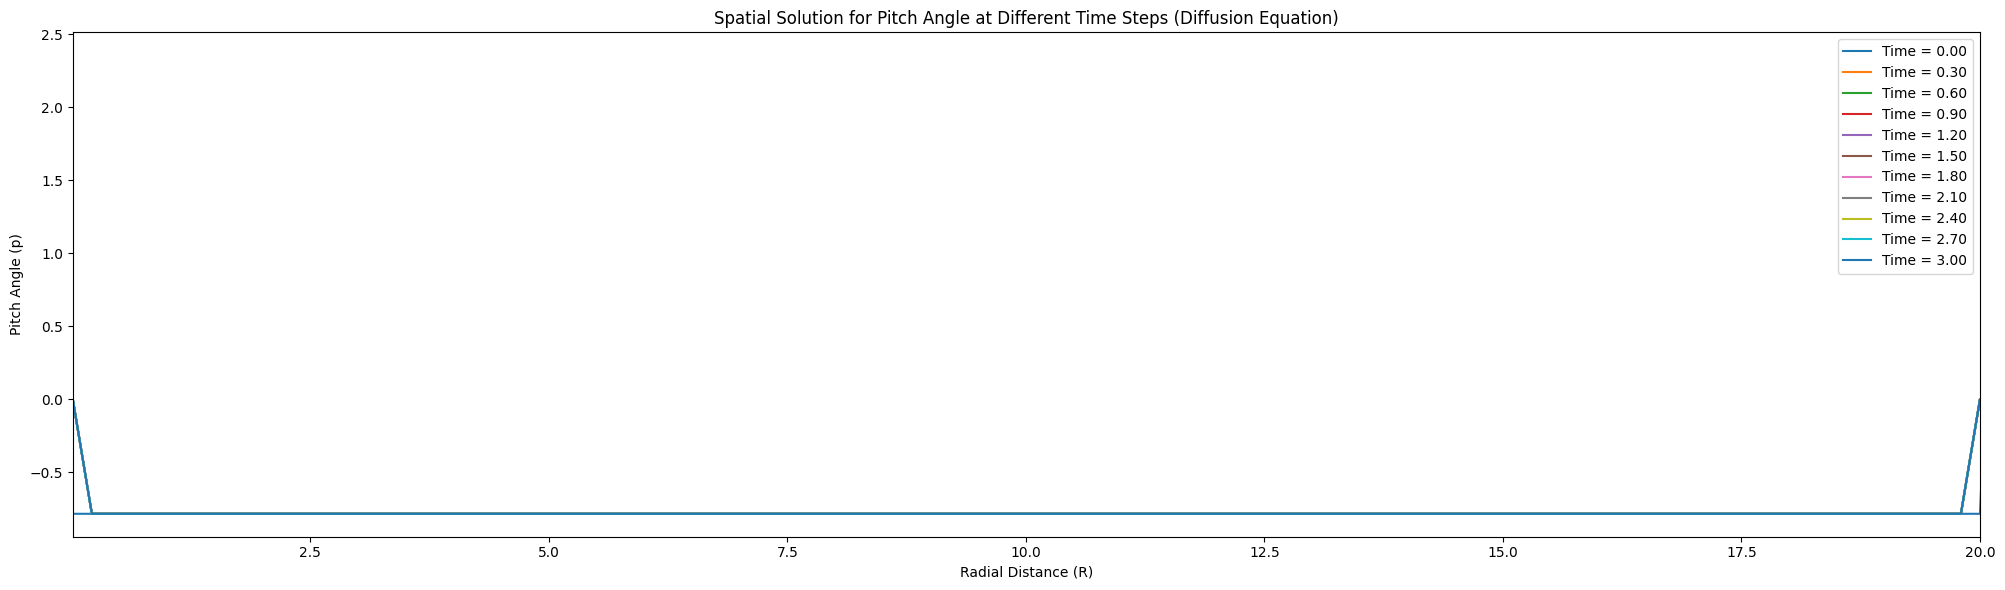

In [51]:
# Function to compute the pitch angle
def Pitch_angle(Br, Bphi):
    return np.arctan2(Br, Bphi)

# Store the evolution of pitch angle at different time steps
evolution_pitch = np.zeros((Nt + 1, Nr))

# Time-stepping scheme using Runge-Kutta
for t in range(Nt + 1):
    evolution_pitch[t, :] = Pitch_angle(Br_Evolution[t, :], Bphi_Evolution[t, :])

# Plot the spatial solution for the pitch angle
plt.figure(figsize=(20, 6))
for t in range(0, Nt + 1, Nt // 10):  # Plot every 10th time step
    plt.plot(r_values, evolution_pitch[t, :], label=f'Time = {t * dt:.2f}')
plt.xlabel('Radial Distance (R)')
plt.ylabel('Pitch Angle (p)')
plt.title('Spatial Solution for Pitch Angle at Different Time Steps (Diffusion Equation)')
plt.legend()
plt.tight_layout()
plt.xlim(r_min,r_max)
plt.show()